Analysis running on device: cpu
Attempting to load model from: models\2025-10-25_09-10-03\mendikot_model_ep_13000.pth


Evaluating Model: 100%|█████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 111.43it/s]



--- Evaluation Results ---
Model: models\2025-10-25_09-10-03\mendikot_model_ep_13000.pth
Games Played: 500
Win Rate vs. Random Agents: 48.40%
Average Reward per Game: -11.70


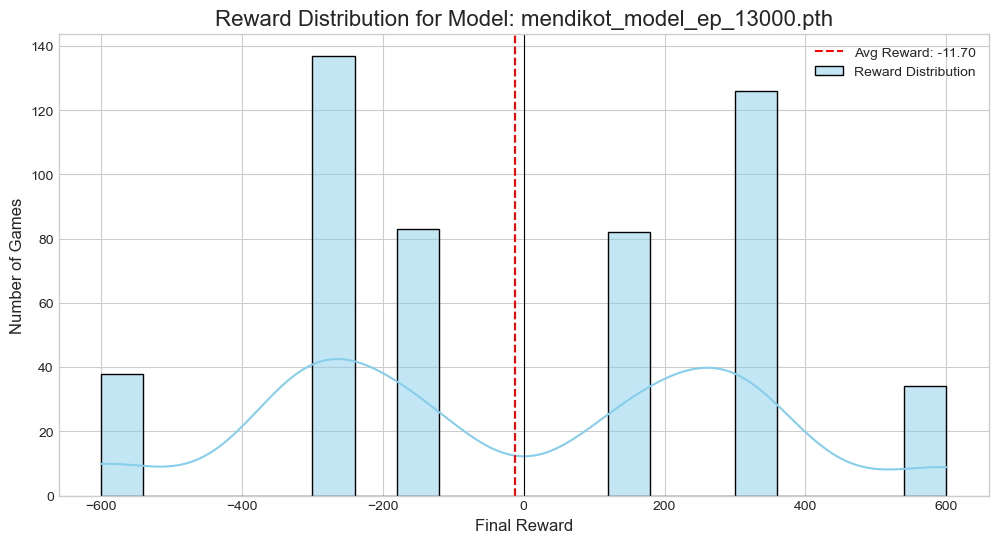

In [1]:
# ====================================================================
#          FINAL MODEL ANALYSIS AND VISUALIZATION SCRIPT
# ====================================================================

# 1. Imports
import torch; import numpy as np; import pandas as pd; import matplotlib.pyplot as plt;
import seaborn as sns; from tqdm import tqdm; import os; import sys;
from itertools import product; import torch.nn as nn;

# 2. Setup Paths and Device
if os.path.basename(os.getcwd()) == 'notebooks': os.chdir('..')
if '.' not in sys.path: sys.path.insert(0, '.')
device = torch.device('cpu')
print(f"Analysis running on device: {device}")

# 3. Game/Model Definitions (Copied for independence)
RANKS_48 = [str(r) for r in range(3, 11)] + ['J', 'Q', 'K', 'A']
SUITS = ['H', 'D', 'C', 'S']
CARD_TO_ID = {f"{rank}{suit}": i for i, (rank, suit) in enumerate(product(RANKS_48, SUITS))}
def get_rank_suit_from_id(card_id):
    rank_idx, suit_idx = card_id // 4, card_id % 4
    return RANKS_48[rank_idx], SUITS[suit_idx]
    
class GameState: # (A simplified version needed for RandomAgent)
    def get_legal_moves(self):
        # This is a placeholder; it will be overwritten by the full GameState from src
        pass 

# We must import the real, full classes from the 'src' files now
from src.game import GameState
from src.agent import MendikotModel
    
# 4. Configuration
RUN_FOLDER_NAME = '2025-10-25_09-10-03' # <-- CHANGE THIS TO YOUR CURRENT RUN'S FOLDER NAME
CHECKPOINT_FILE_NAME = 'mendikot_model_ep_13000.pth'
MODEL_CHECKPOINT_TO_TEST = os.path.join('models', RUN_FOLDER_NAME, CHECKPOINT_FILE_NAME)
NUM_GAMES_TO_SIMULATE = 500
AI_PLAYER_ID, STATE_SIZE, ACTION_SIZE = 0, 272, 12

# 5. Helper Functions & Classes
def state_to_tensor(game_state, player_id):
    # ... (paste the final 272-size state_to_tensor function here)
    my_hand_vec = np.zeros(48); my_hand_vec[game_state.hands[player_id]] = 1
    card_owners_vec = np.zeros((48, 4))
    for card_idx in range(48):
        owner = game_state.card_owner_history[card_idx]
        if owner > 0: card_owners_vec[card_idx, owner - 1] = 1
    card_owners_vec = card_owners_vec.flatten()
    void_vec = np.zeros((4, 4)); suit_map = {'H': 0, 'D': 1, 'C': 2, 'S': 3}
    for p_id in range(4):
        for suit_char in game_state.void_suits[p_id]: void_vec[p_id, suit_map[suit_char]] = 1
    void_vec = void_vec.flatten()
    trump_vec, lead_suit_vec = np.zeros(4), np.zeros(4)
    if game_state.trump_suit is not None: trump_vec[suit_map.get(game_state.trump_suit, 0)] = 1
    if game_state.current_trick_lead_suit is not None: lead_suit_vec[suit_map.get(game_state.current_trick_lead_suit, 0)] = 1
    player_info = np.array([player_id/4.0, game_state.current_player_index/4.0, game_state.dealer_index/4.0, len(game_state.trick_cards)/4.0])
    scores_vec = np.array([game_state.mendis_captured[0]/4.0, game_state.tricks_captured[0]/ACTION_SIZE, game_state.mendis_captured[1]/4.0, game_state.tricks_captured[1]/ACTION_SIZE])
    state_vector = np.concatenate([my_hand_vec, card_owners_vec, void_vec, trump_vec, lead_suit_vec, player_info, scores_vec])
    return torch.FloatTensor(state_vector).unsqueeze(0)

class RandomAgent:
    def choose_action(self, game_state):
        legal_moves = game_state.get_legal_moves()
        return np.random.choice(legal_moves) if legal_moves else None

def load_trained_agent(model_path, state_size, action_size):
    print(f"Attempting to load model from: {model_path}")
    if not os.path.exists(model_path): print(f"--> ERROR: File not found."); return None
    model = MendikotModel(state_size, action_size); model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device); model.eval(); return model

def evaluate_model(model, num_games, ai_player_id):
    wins, total_rewards = 0, []
    random_agent = RandomAgent()
    for _ in tqdm(range(num_games), desc="Evaluating Model"):
        game = GameState(num_players=4)
        ai_team = game.get_team(ai_player_id)
        while not game.is_game_over():
            player_id = game.current_player_index
            chosen_card = None
            if game.get_team(player_id) == ai_team:
                with torch.no_grad():
                    state_tensor = state_to_tensor(game, player_id).to(device)
                    player_hand = game.hands[player_id]
                    legal_moves = game.get_legal_moves()
                    if not legal_moves: break
                    policy_logits, _ = model(state_tensor)
                    hand_map = {card_id: i for i, card_id in enumerate(player_hand)}
                    legal_hand_indices = [hand_map[card_id] for card_id in legal_moves if card_id in hand_map]
                    best_action_idx = -1; best_logit = -float('inf')
                    for idx in legal_hand_indices:
                        if policy_logits[0, idx] > best_logit: best_logit = policy_logits[0, idx]; best_action_idx = idx
                    if best_action_idx != -1: chosen_card = player_hand[best_action_idx]
            else: chosen_card = random_agent.choose_action(game)
            if chosen_card is None: break
            game.play_card(player_id, chosen_card)
        ai_reward = game.get_final_rewards()[ai_team]
        total_rewards.append(ai_reward)
        if ai_reward > 0: wins += 1
    return wins, total_rewards

# 6. Run the evaluation
trained_model = load_trained_agent(MODEL_CHECKPOINT_TO_TEST, STATE_SIZE, ACTION_SIZE)
if trained_model:
    wins, rewards = evaluate_model(trained_model, NUM_GAMES_TO_SIMULATE, AI_PLAYER_ID)
    # ... (Print and plot results code) ...
    win_rate = (wins / NUM_GAMES_TO_SIMULATE) * 100
    avg_reward = np.mean(rewards)
    print("\n--- Evaluation Results ---")
    print(f"Model: {MODEL_CHECKPOINT_TO_TEST}")
    print(f"Games Played: {NUM_GAMES_TO_SIMULATE}")
    print(f"Win Rate vs. Random Agents: {win_rate:.2f}%")
    print(f"Average Reward per Game: {avg_reward:.2f}")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.histplot(rewards, bins=20, kde=True, ax=ax1, color='skyblue', label='Reward Distribution')
    ax1.set_title(f'Reward Distribution for Model: {os.path.basename(MODEL_CHECKPOINT_TO_TEST)}', fontsize=16)
    ax1.set_xlabel('Final Reward', fontsize=12); ax1.set_ylabel('Number of Games', fontsize=12)
    ax1.axvline(avg_reward, color='red', linestyle='--', label=f'Avg Reward: {avg_reward:.2f}')
    ax1.axvline(0, color='black', linestyle='-', linewidth=0.8)
    ax1.legend()
    plt.show()